In [170]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.python.keras.models import load_model
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["synfalse_transfers"]
colltrue = transferdb["true_transfers"]
colltrue_test = transferdb["true_test_transfers"]
collfalse_test = transferdb["synfalse_test_transfers"]

df_true = pd.read_json("./true_transfers.json", lines=True)
df_false = pd.read_json("./false.json", lines=True)


# df_false = pd.DataFrame(list(collfalse.find()))
# df_true = pd.DataFrame(list(colltrue.find()))


df_true_test = pd.read_json("./true_test.json", lines=True)
df_false_test = pd.read_json("./false_test.json", lines=True)
# df_true_test = pd.DataFrame(list(colltrue_test.find()))
# df_false_test = pd.DataFrame(list(collfalse_test.find()))



# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [171]:
def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [172]:
# making the training sets
shuffeled_true = df_true.sample(frac=1)
shuffeled_false = df_false.sample(frac=1)
shuffeled = pd.concat([shuffeled_true.head(50000), shuffeled_false]).sample(frac=1)
training_examples = preprocess_features(shuffeled.head(80000))
training_targets = preprocess_targets(shuffeled.head(80000))

validation_examples = preprocess_features(shuffeled.tail(18000))
validation_targets = preprocess_targets(shuffeled.tail(18000))

shuffeled_true_test = df_true_test.sample(frac=1)
shuffeled_false_test = df_false_test.sample(frac=1)
shuffeled_test = pd.concat([shuffeled_true_test, shuffeled_false_test]).sample(frac=1)
test_examples = preprocess_features(shuffeled_test.head(8000))
test_targets = preprocess_targets(shuffeled_test.head(8000))




In [173]:
print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

print("Test examples summary:")
display.display(test_examples)
print("Test targets summary:")
display.display(test_targets)



Training examples summary:


[u'Real Madrid ready to launch Eden Hazard Chelsea transfer raid - reports http:// dld.bz/fZwGJ',
 u"Transfers : Manchester United 's Guillermo Varela agrees loan to Eintracht Frankfurt , sources tell ESPN FC (ESPN) http:// ift.tt/VTgg6W #S \u2026",
 u'Liverpool transfer news: Jurgen Klopp keen for Ben Woodburn to join Sheffield United on loan deal http://www. soccerfric.com/liverpool-tran sfer-news-jurgen-klopp-keen-for-ben-woodburn-to-join-sheffield-united-on-loan-deal/ \u2026 pic.twitter.com/5cnJQ5bTvk',
 u'Sports #Sports_News Mats Hummels Barcelona Transfer News: Catalonia Giants to Hijack Manchester United\u2019s Bid for... http:// dlvr.it/6G7Dpr',
 u"#ManchesterUnited #ManUTD Manchester United target Pierre-Emerick Aubameyang 's transfer to PSG in doubt over \u20ac.. http:// dld.bz/fNEyB",
 u'#ChelseaFC & #RealMadrid agreed terms for the transfer of Thibaut Courtois. As part of the deal , Mateo Kovacic will join Chelsea on a season-long loan. pic.twitter.com/v40FdxuvZx',
 u'Yes w

Validation examples summary:


[u'@GuillemBalague @BumperGraham any truth to the Griezmann transfer talk surfacing again with Chelsea ?',
 u'Manchester United \u2018in pole position to complete Dani Alves transfer deal\u2019 http:// bit.ly/1KzrAtG',
 u'Report: USMNT goalkeeper Brad Guzan will return to MLS, sign with Atlanta United',
 u'TRANSFER WATCH: Arsenal &#039;s Khedira boost, Lavezzi to Liverpool, Newcastle&#039;s\u2026 http:// goo.gl/fb/dGJjtH #CFC',
 u"Hasn't Thauvin triggered his transfer to Marseille through apps?",
 u'Real Madrid ready to sell Gareth Bale to Manchester United to fund Kylian Mbappe transfer http:// bit.ly/2eN4o6s #football #footballnews pic.twitter.com/KrEoXkKa9i',
 u'you think Chelsea will sign Benzema Bale AND Isco?',
 u'Arsenal transfer news and rumours: Wojciech Szczesny edges closer to permanent Juventus move http://www. mirror.co.uk/sport/football /transfer-news/arsenal-summer-transfer-window-news-10767079 \u2026 pic.twitter.com/9xGyxW1mKc',
 u'Sports Toni Kroos Latest Transfer News

Training targets summary:


[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0

Validation targets summary:


[0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0

Test examples summary:


[u'Biggest mistake jamie vardy will ever make is signing for Arsenal ! Should have stuck with Leicester and made himself a legend',
 u'LOL  @piesportsbooze : BREAKING. Brendan Rodgers is having a medical at Liverpool after agreeing to spend \xa332.5 million on Christian Benteke"',
 u"Liverpool Transfer News: Latest on Sadio Mane and Marko Pjaca Rumours: Nathan Redmond's transfer to Southampt... http:// ble.ac/292ln07",
 u'Petr Cech is a fantastic signing for Arsenal . However, it just proves how strong Chelsea are, when we have an even better goalkeeper! #cfc',
 u'Jamie Vardy to Arsenal : Gunners confident of sealing transfer within 24 hours as Leicester fight to keep striker http:// tinyurl.com/hd36wws',
 u'Manchester United will sign Argentina number one Sergio Romero this weekend (ESPN) #mufc',
 u"Really think Sadio Mane is a good signing for Liverpool . He's was one of the main players in premier league. Can see him do well #LFC",
 u'Manchester United transfer news: Henrikh Mkhitar

Test targets summary:


[0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0

In [63]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [64]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, training_targets, validation_examples)
print(x_val)

  (0, 1861)	0.22452079
  (0, 1863)	0.22529268
  (0, 4068)	0.09756676
  (0, 4143)	0.23806602
  (0, 5522)	0.14185202
  (0, 5523)	0.14185819
  (0, 6629)	0.14167346
  (0, 6668)	0.18831556
  (0, 7808)	0.19660954
  (0, 7835)	0.26154056
  (0, 8511)	0.067841426
  (0, 8532)	0.14458704
  (0, 9194)	0.12767276
  (0, 13152)	0.19413145
  (0, 13157)	0.30585718
  (0, 14817)	0.15874311
  (0, 14821)	0.32906508
  (0, 16152)	0.25827718
  (0, 16158)	0.34197152
  (0, 17306)	0.054057907
  (0, 17618)	0.31546172
  (0, 17871)	0.065832615
  (0, 17986)	0.1812438
  (1, 1334)	0.14539346
  (1, 1341)	0.22357339
  :	:
  (9999, 8511)	0.030542389
  (9999, 8531)	0.07025983
  (9999, 10247)	0.0938038
  (9999, 10250)	0.100580245
  (9999, 10932)	0.12280993
  (9999, 11056)	0.04340499
  (9999, 11064)	0.04818375
  (9999, 11672)	0.09843952
  (9999, 11675)	0.141142
  (9999, 12937)	0.09416435
  (9999, 12955)	0.12274545
  (9999, 12973)	0.05165217
  (9999, 13255)	0.079789415
  (9999, 17306)	0.04867403
  (9999, 17536)	0.13337483
  (9

In [51]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [52]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [53]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    plt.show()
    
    

In [54]:
def plot_loss(history):
    plt.ylabel("Loss")
    plt.xlabel("Periods")
    plt.title("Training & Validation Loss")
    plt.tight_layout()
    plt.plot(history['loss'], label="training")
    plt.plot(history['val_loss'], label="validation")
    plt.legend()
    plt.show()
    

In [55]:
def roc_curve(history):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
        validation_targets[0:len(history["val_acc"])], history['val_acc'])
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    plt.show()

In [56]:
def calculate_auc(history):
    auc = metrics.roc_auc_score(validation_targets[0:len(history["val_acc"])], history['val_acc'])
    return auc
    

In [57]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    ndarr = np.array(train_labels)
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    auc_score = calculate_auc(history)
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc_score

Train on 80000 samples, validate on 18000 samples
Epoch 1/20
 - 19s - loss: 0.6040 - acc: 0.6545 - val_loss: 0.3261 - val_acc: 0.9750
Epoch 2/20
 - 17s - loss: 0.4960 - acc: 0.7433 - val_loss: 0.2296 - val_acc: 0.9831
Epoch 3/20
 - 17s - loss: 0.4670 - acc: 0.7666 - val_loss: 0.2111 - val_acc: 0.9848
Epoch 4/20
 - 17s - loss: 0.4611 - acc: 0.7671 - val_loss: 0.2044 - val_acc: 0.9848
Epoch 5/20
 - 17s - loss: 0.4556 - acc: 0.7700 - val_loss: 0.1980 - val_acc: 0.9858
Epoch 6/20
 - 17s - loss: 0.4539 - acc: 0.7711 - val_loss: 0.1977 - val_acc: 0.9876
Epoch 7/20
 - 18s - loss: 0.4519 - acc: 0.7728 - val_loss: 0.1984 - val_acc: 0.9875
Epoch 8/20
 - 17s - loss: 0.4513 - acc: 0.7721 - val_loss: 0.1974 - val_acc: 0.9874
Epoch 9/20
 - 18s - loss: 0.4515 - acc: 0.7708 - val_loss: 0.1965 - val_acc: 0.9876
Epoch 10/20
 - 18s - loss: 0.4526 - acc: 0.7710 - val_loss: 0.1939 - val_acc: 0.9877
Epoch 11/20
 - 17s - loss: 0.4508 - acc: 0.7711 - val_loss: 0.1952 - val_acc: 0.9883
Epoch 12/20
 - 18s - los

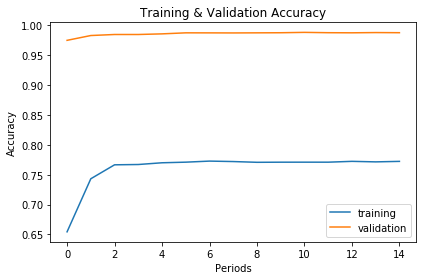

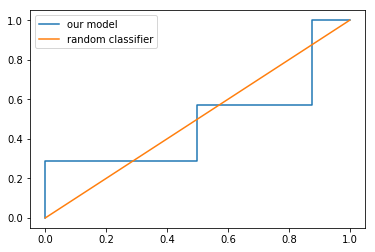

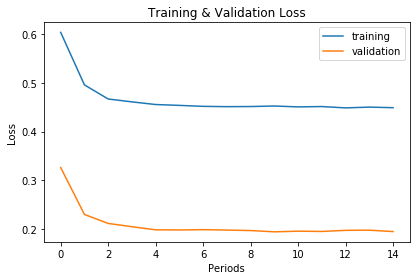

(0.98777777, 0.19442514696386126, 0.4821428571428571)

In [69]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=0.001,
                      epochs=20,
                      batch_size=128,
                      layers=4,
                      units=4,
                      dropout_rate=0.5)

In [16]:
def make_prediction(tweet_text):
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
#     print(tweet_text)
    x_train, x_val = ngram_vectorize(
        training_examples, training_targets, tweet_text)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(x_val)
    print(prediction)

In [ ]:
def evaluate_model():
    x_train, test_set = ngram_vectorize(training_examples, training_targets, test_examples)
#     x_train, test_labels = ngram_vectorize(training_examples, training_targets, test_targets)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)
    
    

In [36]:
evaluate_model()


4000/4000 [==============================] - 1s 186us/sample - loss: 3.4536 - acc: 0.5115


In [98]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [71]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [103]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [104]:
def evaluate_seq_model():
    x_train, test_set = sequence_vectorize(training_examples, test_examples)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)

In [161]:
def train_seq_model(data,
                      learning_rate,
                      epochs,
                      batch_size,
                      layers,
                      units,
                      dropout_rate):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=layers, filters=4, kernel_size=4, embedding_dim=200, dropout_rate=dropout_rate, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=TOP_K)
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    auc_score = calculate_auc(history)
    
    # Save model.
    model.save('twitter_model_seq.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc_score

In [164]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data=data,
                      learning_rate=0.1,
                      epochs=20,
                      batch_size=64,
                      layers=2,
                      units=1,
                      dropout_rate=0.2)

(80000, 94)
(18000, 94)
Train on 80000 samples, validate on 18000 samples
Epoch 1/20
 - 128s - loss: 0.6946 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5042
Epoch 2/20
 - 118s - loss: 0.6944 - acc: 0.5004 - val_loss: 0.6934 - val_acc: 0.4958
Epoch 3/20
 - 115s - loss: 0.6948 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.4958
Epoch 4/20


KeyboardInterrupt: 

In [ ]:
evaluate_seq_model()